In [1]:
import numpy as np
import pandas as pd
import pickle

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import activations
from keras import metrics
import math

import random

# to make the experimens replicable
random.seed(123456)

Using TensorFlow backend.


## Important

as first step run the notebook `1. classification-dataset-creation.ipynb` to create the dataset.

In [2]:
dataset_path = 'regione-toscana/dataset-dirigenti.pkl'

with open(dataset_path, 'rb') as f:
    samples, labels = pickle.load(f)

### Transform it in a dataset

In [3]:
samples[:5]

array(["DGR 968/07 e s.m.i. Accreditamento degli organismi formativi. Rilascio dell'accreditamento all'organismo formativo Bioscience Research Center - cod. GR1035.",
       'Nomina Commissione d’esame per il percorso formativo “Formazione obbligatoria per utilizzatori professionali di prodotti fitosanitari”, MATRICOLA N. 2016SI0046',
       "Nomina della Commissione d'esame matricola 2016PI0301. Agenzia Formativa Cescot",
       'Progetti formativi per drop-out a.s.f. 2015-2016. Integrazione impegno per progetto "Figaro - Operatore del benessere (acconciatura)"',
       'REG (CE) 1080/2006-Por Creo Fesr 2007-2013-Linea di intevento 5.1.d-Chiusura attività'],
      dtype='<U961')

In [4]:
labels[:5]

array(['50125', '50125', '50125', '50125', '50125'], dtype='<U5')

In [5]:
samples = np.array(samples)
labels = np.array(labels)

## Train, Val and Test Set

Normally we split the dataset into:
- 70% for training
- 10% for validation
- 20% for testing

In [6]:
samples.shape

(147463,)

### Shuffle Data

In [7]:
indices = list(range(len(samples)))
np.random.shuffle(indices)

samples = samples[indices]
labels = labels[indices]

In [8]:
labels[:5]

array(['50005', '50117', '50000', '50117', '50125'], dtype='<U5')

## Tokenize the Dataset

In [9]:
from keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(samples)

In [11]:
sequences = tokenizer.texts_to_sequences(samples)

In [12]:
[print(s) for s in sequences[:2]]

[11, 11, 151, 20, 84, 223, 176, 89, 1, 146, 140, 1, 226, 2, 71, 1, 787, 4, 7, 354, 3, 547, 564, 358, 2023, 25, 1294, 9, 433, 18, 223, 176, 9, 29]
[7, 6, 24, 90, 23, 335, 33, 63, 1, 218, 319, 449, 548, 345, 277, 143, 6696]


[None, None]

Convert labels to sequences

In [13]:
index_to_labels = dict(enumerate(set(labels)))
labels_to_index = {v:k for k,v in index_to_labels.items()}

In [14]:
labels_to_index

{'01025': 29,
 '01027': 31,
 '01923': 30,
 '01928': 1,
 '01931': 2,
 '01934': 11,
 '01937': 17,
 '01943': 7,
 '01946': 27,
 '02090': 13,
 '50000': 8,
 '50001': 26,
 '50002': 12,
 '50003': 10,
 '50004': 21,
 '50005': 14,
 '50006': 25,
 '50007': 28,
 '50069': 6,
 '50073': 19,
 '50079': 3,
 '50083': 15,
 '50102': 5,
 '50115': 22,
 '50116': 23,
 '50117': 24,
 '50118': 18,
 '50119': 9,
 '50123': 16,
 '50125': 4,
 '50127': 0,
 '50202': 20}

In [15]:
len(labels_to_index)

32

In [16]:
labels

array(['50005', '50117', '50000', ..., '50005', '50125', '50116'],
      dtype='<U5')

In [17]:
encoded_labels = [labels_to_index[l] for l in labels]

In [18]:
encoded_labels[:10]

[14, 24, 8, 24, 4, 22, 10, 9, 8, 18]

## Train, Val and Test Set

Normally, we split the dataset into:
- train: 70%
- val: 10%
- test: 20%

In [19]:
training_size = math.trunc(len(sequences) * 0.7)
val_size = math.trunc(len(sequences) * 0.8)
test_size = len(sequences)

In [20]:
train_data = sequences[:training_size]
train_labels = encoded_labels[:training_size]

val_data = sequences[training_size:val_size]
val_labels = encoded_labels[training_size:val_size]

test_data = sequences[val_size:]
test_labels = encoded_labels[val_size:] 

### Preparing Data

for data and labels

In [21]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [22]:
x_train = vectorize_sequences(train_data)
x_val = vectorize_sequences(val_data)
x_test = vectorize_sequences(test_data)

In [23]:
x_train[0:]

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]], dtype=float32)

In [24]:
x_train.shape

(103224, 10000)

One hot encoding for the labels

In [25]:
def to_one_hot(labels):
    results = np.zeros((len(labels), len(set(labels))), dtype=np.float32)
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [26]:
y_train = to_one_hot(train_labels)
y_val = to_one_hot(val_labels)
y_test = to_one_hot(test_labels)

In [27]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Build the Models

In [28]:
def build_model(neurons):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_shape=(x_train.shape[-1], )))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dense(len(labels_to_index), activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [29]:
model_small = build_model(16)
model_medium = build_model(64)
model_large = build_model(256)

In [30]:
history_small = model_small.fit(x=x_train, y=y_train, validation_data=(x_val,y_val),
                   epochs=10, batch_size=256)

Train on 103224 samples, validate on 14746 samples
Epoch 1/10
103224/103224 [==============================] - 5s 45us/step - loss: 2.0444 - acc: 0.4225 - val_loss: 1.2097 - val_acc: 0.6377
Epoch 2/10
103224/103224 [==============================] - 3s 29us/step - loss: 0.9858 - acc: 0.6940 - val_loss: 0.9370 - val_acc: 0.7040
Epoch 3/10
103224/103224 [==============================] - 3s 29us/step - loss: 0.7762 - acc: 0.7508 - val_loss: 0.8530 - val_acc: 0.7283
Epoch 4/10
103224/103224 [==============================] - 3s 30us/step - loss: 0.6713 - acc: 0.7797 - val_loss: 0.8220 - val_acc: 0.7363
Epoch 5/10
103224/103224 [==============================] - 3s 29us/step - loss: 0.6024 - acc: 0.8002 - val_loss: 0.8197 - val_acc: 0.7414
Epoch 6/10
103224/103224 [==============================] - 3s 31us/step - loss: 0.5541 - acc: 0.8148 - val_loss: 0.8112 - val_acc: 0.7458
Epoch 7/10
103224/103224 [==============================] - 3s 28us/step - loss: 0.5157 - acc: 0.8262 - val_loss: 0

In [31]:
history_medium = model_medium.fit(x=x_train, y=y_train, validation_data=(x_val,y_val),
                   epochs=10, batch_size=256)

Train on 103224 samples, validate on 14746 samples
Epoch 1/10
103224/103224 [==============================] - 4s 35us/step - loss: 1.3316 - acc: 0.6087 - val_loss: 0.7750 - val_acc: 0.7452
Epoch 2/10
103224/103224 [==============================] - 3s 26us/step - loss: 0.6153 - acc: 0.7915 - val_loss: 0.6893 - val_acc: 0.7678
Epoch 3/10
103224/103224 [==============================] - 3s 25us/step - loss: 0.4737 - acc: 0.8359 - val_loss: 0.6738 - val_acc: 0.7778
Epoch 4/10
103224/103224 [==============================] - 3s 25us/step - loss: 0.3930 - acc: 0.8627 - val_loss: 0.6906 - val_acc: 0.7776
Epoch 5/10
103224/103224 [==============================] - 3s 26us/step - loss: 0.3330 - acc: 0.8837 - val_loss: 0.7265 - val_acc: 0.7792
Epoch 6/10
103224/103224 [==============================] - 3s 25us/step - loss: 0.2855 - acc: 0.9001 - val_loss: 0.7567 - val_acc: 0.7816
Epoch 7/10
103224/103224 [==============================] - 3s 26us/step - loss: 0.2474 - acc: 0.9138 - val_loss: 0

In [32]:
history_large = model_large.fit(x=x_train, y=y_train, validation_data=(x_val,y_val),
                   epochs=10, batch_size=256)

Train on 103224 samples, validate on 14746 samples
Epoch 1/10
103224/103224 [==============================] - 6s 53us/step - loss: 1.0511 - acc: 0.6750 - val_loss: 0.6666 - val_acc: 0.7684
Epoch 2/10
103224/103224 [==============================] - 5s 50us/step - loss: 0.4766 - acc: 0.8315 - val_loss: 0.6131 - val_acc: 0.7901
Epoch 3/10
103224/103224 [==============================] - 5s 50us/step - loss: 0.3147 - acc: 0.8865 - val_loss: 0.6246 - val_acc: 0.7942
Epoch 4/10
103224/103224 [==============================] - 5s 50us/step - loss: 0.2183 - acc: 0.9219 - val_loss: 0.6678 - val_acc: 0.8032
Epoch 5/10
103224/103224 [==============================] - 5s 51us/step - loss: 0.1612 - acc: 0.9433 - val_loss: 0.7569 - val_acc: 0.8032
Epoch 6/10
103224/103224 [==============================] - 5s 51us/step - loss: 0.1248 - acc: 0.9565 - val_loss: 0.8086 - val_acc: 0.8029
Epoch 7/10
103224/103224 [==============================] - 6s 55us/step - loss: 0.1021 - acc: 0.9657 - val_loss: 0

### Printing The Loss

In [39]:
import matplotlib.pyplot as plt

%matplotlib inline

In [40]:
def chart_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'b+', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

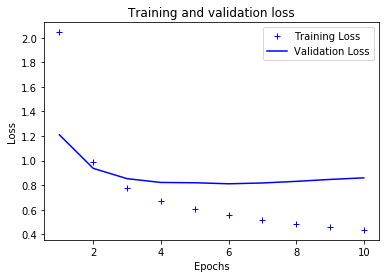

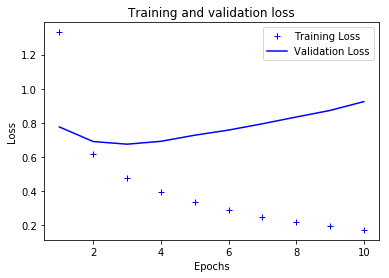

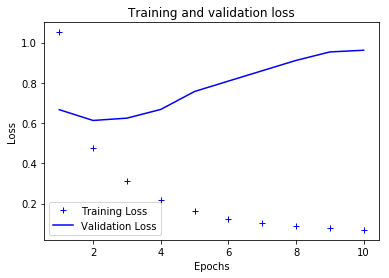

In [41]:
chart_loss(history_small)
chart_loss(history_medium)
chart_loss(history_large)

In [42]:
def chart_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b+', label='Training Acc')
    plt.plot(epochs, val_acc, 'b', label='Validation Acc')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuray')
    plt.legend()
    plt.show()

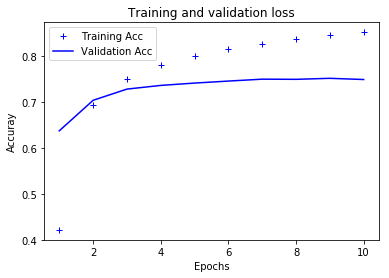

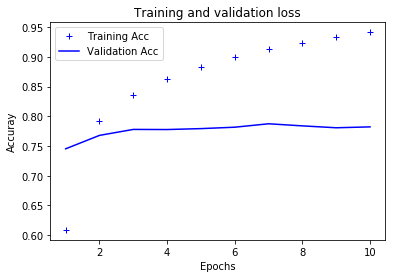

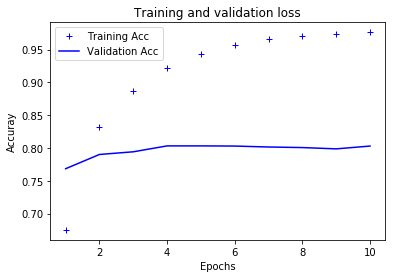

In [43]:
chart_acc(history_small)
chart_acc(history_medium)
chart_acc(history_large)

In [44]:
def compare_loss(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_loss']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, label='Validation Loss {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

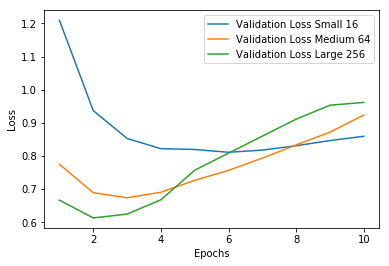

In [49]:
compare_loss({'Small 16': history_small, 'Medium 64': history_medium, 'Large 256': history_large})

In [46]:
def compare_accuracy(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_acc']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_acc']
        plt.plot(epochs, val_loss, label='Validation Accuracy {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

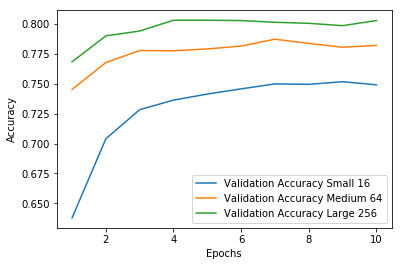

In [48]:
compare_accuracy({'Small 16': history_small, 'Medium 64': history_medium, 'Large 256': history_large})

### Evaluate on the Test Set

- train the best model for the best epochs

In [50]:
model = build_model(64)

In [51]:
history = model.fit(x=x_train, y=y_train, epochs=4, validation_data=(x_val, y_val), batch_size=256)

Train on 103224 samples, validate on 14746 samples
Epoch 1/4
103224/103224 [==============================] - 3s 28us/step - loss: 1.3328 - acc: 0.6073 - val_loss: 0.7645 - val_acc: 0.7426
Epoch 2/4
103224/103224 [==============================] - 3s 25us/step - loss: 0.6091 - acc: 0.7930 - val_loss: 0.6765 - val_acc: 0.7716
Epoch 3/4
103224/103224 [==============================] - 3s 25us/step - loss: 0.4762 - acc: 0.8345 - val_loss: 0.6695 - val_acc: 0.7776
Epoch 4/4
103224/103224 [==============================] - 3s 25us/step - loss: 0.3951 - acc: 0.8620 - val_loss: 0.6839 - val_acc: 0.7784


In [52]:
loss, acc = model.evaluate(x_test, y_test)

29493/29493 [==============================] - 2s 52us/step


In [53]:
print('loss {}'.format(loss))
print('acc {}'.format(acc))

loss 0.6839909429399487
acc 0.7804224731413429
